# GCNとVGAEの比較
Graph Convolution Network(GCN)によるリンク予測とVariational Graph Auto-Encoder(VGAE)のネットワーク生成における信用スコアリングシステムとして比較を行う

**仮説**
- 課題: GCNによるリンク予測は取引が不十分なネットワークでは新たな取引の予測が困難である
    - リンク予測では十分な取引ネットワークでは予測することが可能であるものの取引が不十分なスパースなネットワークでは信用度算出が困難である
    - 過去の実験からほとんどのユーザーは取引が少なく一部のユーザーに取引が集中している場合が多くほとんどのユーザーの信用度が0に近い値になってしまう
- 目的: VGAEにおけるネットワーク生成はGCNのリンク予測に対してスパースなネットワークで有効であることを検証する

In [1]:
# GPU&PyTorchの動作確認
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Aug 19 2025, 12:03:11) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得
### neo4jのグラフデータベースからデータを取得する

In [2]:
from neo4j import GraphDatabase
import pandas as pd

# neo4j serverに接続するdriverの設定
driver = GraphDatabase.driver('neo4j://graph-db:7687')

# 取引データを取得する
def fetch_transaction(tx, contract_address = "all"):
    query = "MATCH p=()-[r:TRANSFER]->() RETURN p"
    if contract_address != "all":
        query = """
        MATCH p=()-[r:TRANSFER]->()
        WHERE r.contractAddress = $address
        RETURN p
        """
    transactions = tx.run(query, address=contract_address)
    return list(transactions)

contract_address = "all"  # 全てのトランザクションを取得する場合は "all" を指定
transactions = list()
relations = list()

# neo4jに接続してトランザクションを実行
with driver.session() as session:
    transactions = session.execute_read(fetch_transaction, contract_address)

# トランザクションの結果をリストに保存
for transaction in transactions:
    path = transaction["p"]
    relationship = path.relationships[0]

    relations.append({
        "tokenId": relationship["tokenId"],
        "from": path.start_node["address"], 
        "to": path.end_node["address"],
        "gasPrice": relationship["gasPrice"],
        "gasUsed": relationship["gasUsed"],
        "contractAddress": relationship["contractAddress"],
        "tokenUri": relationship["tokenUri"],
        "blockNumber": relationship["blockNumber"],
    })

# 結果をdataframeで保存して表示
df_relation = pd.DataFrame(relations)
address_counts = df_relation['contractAddress'].value_counts()
df_contract_summary = pd.DataFrame({
    'contractAddress': address_counts.index,
    'transaction_count': address_counts.values
})
display(df_contract_summary)

,contractAddress,transaction_count
0,0x42069ABFE407C60cf4ae4112bEDEaD391dBa1cdB,35654
1,0x620b70123fB810F6C653DA7644b5dD0b6312e4D8,9165
2,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,3376
3,0x6dBccC65133635D27AE56B7E3586b6e810d92082,261
4,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D,146
5,0x76B50696B8EFFCA6Ee6Da7F6471110F334536321,35
6,0x32F4866B63CaDeD01058540Cff9Bb1fcC05E1cb7,29


In [3]:
df_test = df_relation[df_relation["contractAddress"] == "0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D"]
df_relation = df_relation[df_relation["contractAddress"] != "0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D"]

# CSVに保存
df_relation.to_csv("/trust-engine/2025/ses_data/relations.csv", index=True)
df_test.to_csv("/trust-engine/2025/ses_data/test_relations.csv", index=True)

# 結果の表示
print(f"df_relation: Number of transactions = {len(df_relation)}")
print(f"df_test: Number of transactions = {len(df_test)}")

df_relation: Number of transactions = 48520
df_test: Number of transactions = 146


### 学習用のグラフデータの可視化

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

graph = nx.DiGraph()
graph.add_nodes_from(pd.concat([df_relation["from"], df_relation["to"]]).unique())
for index, transaction in df_relation.iterrows():
    graph.add_edge(transaction["from"], transaction["to"])
print(f"ネットワーク: ノード数={graph.number_of_nodes()}, エッジ数={graph.number_of_edges()}")

ネットワーク: ノード数=13695, エッジ数=24856


### 頂点特徴量を求める
- NFT取引においてユーザーの頂点特徴量は利用できないためネットワーク構造とトランザクション情報を取り扱う
- 中心性を用いてネットワークの構造を捉える
- ガス代とブロック番号からトランザクション情報をとらえる
    - ガス代: トランザクションの重要度
    - ブロック番号: トランザクションの時系列情報

In [5]:
df_feature = pd.DataFrame(
    index=list(graph.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 中心性の計算
degree = nx.in_degree_centrality(graph)
betweenness = nx.betweenness_centrality(graph)
pagerank = nx.pagerank(graph)

# ガス代を集計
gas_from = df_relation.groupby('from')[['gasPrice', 'gasUsed']].sum()
gas_to = df_relation.groupby('to')[['gasPrice', 'gasUsed']].sum()
gas_combined = gas_from.add(gas_to, fill_value=0)

# ブロック番号を追加
block_from = df_relation.groupby('from')['blockNumber'].first()
block_to = df_relation.groupby('to')['blockNumber'].first()
block_combined = pd.concat([block_from, block_to]).groupby(level=0).first()

# データフレームに追加
for node in df_feature.index:
    if node in degree:
        df_feature.loc[node, "degree"] = degree[node]
    if node in betweenness:
        df_feature.loc[node, "betweenness"] = betweenness[node]
    if node in pagerank:
        df_feature.loc[node, "pagerank"] = pagerank[node]
    if node in gas_combined.index:
        df_feature.loc[node, 'gasPrice'] = gas_combined.loc[node, 'gasPrice']
        df_feature.loc[node, 'gasUsed'] = gas_combined.loc[node, 'gasUsed']
    if node in block_combined.index:
        df_feature.loc[node, 'blockNumber'] = block_combined.loc[node]

# CSVに保存
df_relation.to_csv("/trust-engine/2025/ses_data/relations.csv", index=True)

# 正規化
df_feature = (df_feature - df_feature.min()) / (df_feature.max() - df_feature.min())

# データ型の変換
df_feature = df_feature.astype({
    "degree": "float32",
    "betweenness": "float32",
    "pagerank": "float32",
    "gasPrice": "float32",
    "gasUsed": "float32",
    "blockNumber": "float32",
})

# 結果の表示
display(df_feature.head())
display(df_feature.info())

,degree,betweenness,pagerank,gasPrice,gasUsed,blockNumber
0xb8a150AcfC753C81e5581D07Bb2eAf6589D5f5D7,0.000000,0.000000e+00,0.000000,0.000038,0.000058,0.975490
0xdc3F4b133561ab3278CF50740b9b6AC6cAb34fF1,0.000999,1.684262e-03,0.000346,0.000517,0.000191,0.984383
0xD6Dab4691EE54FD06b3E834c90b78ff5cb633ee8,0.001332,1.839421e-03,0.000625,0.000761,0.000286,0.987644
0xe25ACC4ee8311F06bfB688f7363ac6dEF7650D28,0.000000,0.000000e+00,0.000000,0.000120,0.000031,0.994936
0x23FBD8Efe84B35a746b2Fe2a96bcdA2578f57D53,0.000333,2.687563e-08,0.000186,0.000241,0.000073,0.994975


<class 'pandas.core.frame.DataFrame'>
Index: 13695 entries, 0xb8a150AcfC753C81e5581D07Bb2eAf6589D5f5D7 to 0xDbAacdcadD7c51a325B771ff75B261a1e7baE11c
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   degree       13695 non-null  float32
 1   betweenness  13695 non-null  float32
 2   pagerank     13695 non-null  float32
 3   gasPrice     13695 non-null  float32
 4   gasUsed      13695 non-null  float32
 5   blockNumber  13695 non-null  float32
dtypes: float32(6)
memory usage: 944.0+ KB


None

### データ構造をNetworkXからPyTorch Dataに変換する

In [6]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_relation['from'], df_relation['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_relation.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_featureから取得
x = torch.tensor(df_feature.loc[unique_nodes].values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=False, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")
print(f"TEST       node num: {test_data.x.size(0)}, edge num: {test_data.edge_index.size(1)}, node feature num: {test_data.num_node_features}")

/app/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /app/.venv/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops11multinomial4callERKNS_6TensorElbSt8optionalINS_9GeneratorEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/app/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /app/.venv/lib/python3.12/site-packages/torch_sparse/_hgt_sample_cuda.so: undefined symbol: _ZN2at4_ops11multinomial4callERKNS_6TensorElbSt8optionalINS_9GeneratorEE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


TRAIN      node num: 13695, edge num: 38816, node feature num: 6
VALIDATION node num: 13695, edge num: 38816, node feature num: 6
TEST       node num: 13695, edge num: 43668, node feature num: 6


## GCNとVGAEの実装

### モデルの定義

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE

In [8]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [9]:
# VGAE
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [10]:
in_channels = train_data.x.size(-1)
out_channels = 6
gcn_model = GCN(in_channels=in_channels, out_channels=out_channels)
vgae_model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")

入力特徴量の次元: 6, 出力特徴量の次元: 6


## モデルの学習
- 学習回数: 100回
- パラメータの更新: Adam

In [11]:
# データをGPUに転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
epoch_num = 100

### GCNの学習

In [12]:
from torch_geometric.utils import negative_sampling

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
gcn_model = gcn_model.to(device) # 利用するデバイスを選択
best_loss = float('inf')
best_gcn_model = None

for epoch in range(1, epoch_num + 1):
    gcn_model.train()
    optimizer.zero_grad()
    
    # モデルの出力
    out = gcn_model(train_data.x, train_data.edge_index)

    # 正のエッジをサンプリング
    num_pos_edges = train_data.edge_index.size(1)
    pos_edge_index = train_data.edge_index[:, :num_pos_edges]
    edge_embeddings_src = out[pos_edge_index[0]]
    edge_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(edge_embeddings_src * edge_embeddings_dst, dim=1) # 内積でエッジの存在確率を計算
    
    # 負のエッジをサンプリング
    num_neg_edges = train_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=num_neg_edges
    )   
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    
    # ラベルを作成（正のエッジ=1、負のエッジ=0）
    pos_labels = torch.ones(pos_scores.size(0), device=device)
    neg_labels = torch.zeros(neg_scores.size(0), device=device)
    
    # スコアとラベルを結合
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    
    # 損失計算（バイナリクロスエントロピー）
    loss = F.binary_cross_entropy_with_logits(scores, labels)

    # ベストモデルの保存
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'epoch': epoch,
            'model_state_dict': gcn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, '/trust-engine/2025/ses_data/best_gcn_model.pth')
        best_gcn_model = gcn_model
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.5736
Epoch 20, Loss: 0.5686
Epoch 30, Loss: 0.5613
Epoch 40, Loss: 0.5626
Epoch 50, Loss: 0.5610
Epoch 60, Loss: 0.5629
Epoch 70, Loss: 0.5626
Epoch 80, Loss: 0.5546
Epoch 90, Loss: 0.5601
Epoch 100, Loss: 0.5589


### VGAEの学習

In [13]:
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=0.01)
vgae_model = vgae_model.to(device) # 利用するデバイスを選択
best_loss = float('inf')
best_vgae_model = None

for epoch in range(1, epoch_num + 1):
    vgae_model.train()
    optimizer.zero_grad()

    # モデルの出力
    z = vgae_model.encode(train_data.x, train_data.edge_index)

    # 再構成損失とKL損失の計算
    recon_loss = vgae_model.recon_loss(z, train_data.edge_index)
    kl_loss = (1 / train_data.num_nodes) * vgae_model.kl_loss()
    loss = recon_loss + kl_loss

    # ベストモデルの保存
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'epoch': epoch,
            'model_state_dict': vgae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, '/trust-engine/2025/ses_data/best_vgae_model.pth')
        best_vgae_model = vgae_model

    # 勾配の計算
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 10, Loss: 2.234530210494995
Epoch 20, Loss: 1.7895708084106445
Epoch 30, Loss: 1.577166199684143
Epoch 40, Loss: 1.438825249671936
Epoch 50, Loss: 1.3226959705352783
Epoch 60, Loss: 1.25226628780365
Epoch 70, Loss: 1.218758463859558
Epoch 80, Loss: 1.1861788034439087
Epoch 90, Loss: 1.1702821254730225
Epoch 100, Loss: 1.1602237224578857


## GCNとVGAEの検証
- 一つのコミュニティのみの取引ネットワークのみで検証する
- GCNでリンク予測した場合とVGAEでネットワーク生成した場合を比較する

In [14]:
rocs = {
    "GCN": {
        "fpr": [],
        "tpr": [],
        "auc": []
    },
    "VGAE": {
        "fpr": [],
        "tpr": [],
        "auc": []
    }
}

### GCNを用いたリンク予測

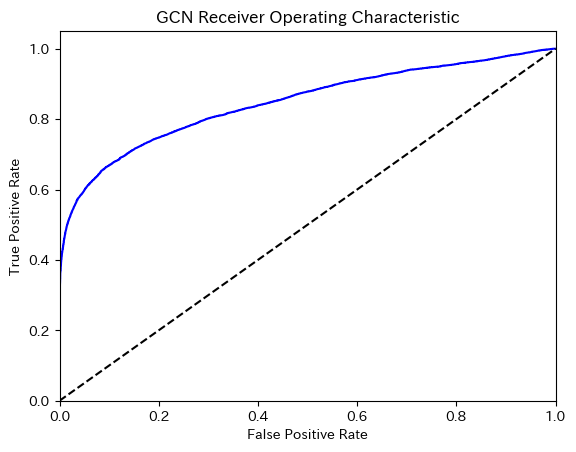

AUC Score: 0.8466
Accuracy: 0.7850
Optimal Threshold: 0.6020
Positive edge predictions (mean): 0.7591
Negative edge predictions (mean): 0.5522


In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

# 学習済みモデルでリンク予測を実行
best_gcn_model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = best_gcn_model(val_data.x, val_data.edge_index)

    # テスト用正のエッジでの予測
    num_pos_edges = val_data.edge_index.size(1)
    pos_edge_index = val_data.edge_index[:, :num_pos_edges]
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)
    
    # テスト用負のエッジでの予測
    num_neg_edges = val_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index,
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)

    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy() 

    # ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))  # 実際に存在するエッジなので1
    neg_labels = torch.zeros(neg_pred.size(0))  # 存在しないエッジなので0
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    rocs["GCN"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    rocs["GCN"]["fpr"] = fpr
    rocs["GCN"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="blue", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('GCN Receiver Operating Characteristic')
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (predictions > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### VGAEにおけるネットワーク生成

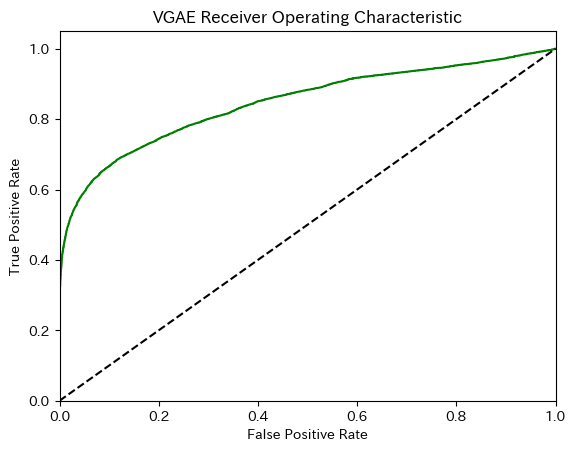

Val VGAE AUC Score: 0.8464
Accuracy: 0.7843
Optimal Threshold: 0.5832
Positive edge predictions (mean): 0.7384
Negative edge predictions (mean): 0.5504


In [16]:
best_vgae_model.eval()
with torch.no_grad():
    z = best_vgae_model.encode(val_data.x, val_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = best_vgae_model.decode(z, val_data.edge_index)

    # 正エッジを予測
    num_pos_edges = val_data.edge_index.size(1)
    pos_edge_index = val_data.edge_index[:, :num_pos_edges]
    pos_pred = best_vgae_model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = val_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index, 
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = best_vgae_model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)
    rocs["VGAE"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)
    rocs["VGAE"]["fpr"] = fpr
    rocs["VGAE"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="green", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('VGAE Receiver Operating Characteristic')
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (preds.numpy() > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    
    print(f"Val VGAE AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

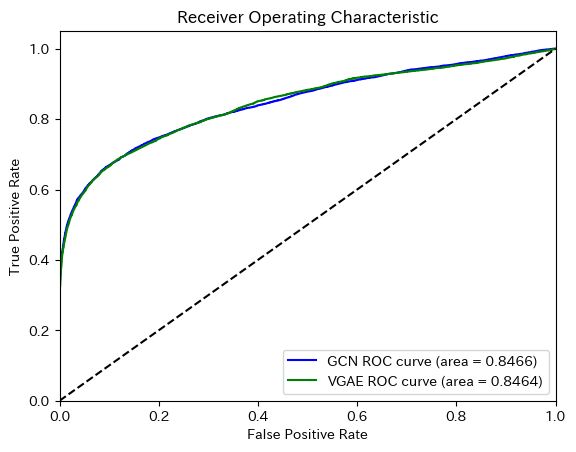

In [17]:
# GCNとVGAEのROC曲線をプロット
plt.figure()
plt.plot(rocs["GCN"]["fpr"], rocs["GCN"]["tpr"], color="blue", label='GCN ROC curve (area = {:.4f})'.format(rocs["GCN"]["auc"]))
plt.plot(rocs["VGAE"]["fpr"], rocs["VGAE"]["tpr"], color="green", label='VGAE ROC curve (area = {:.4f})'.format(rocs["VGAE"]["auc"]))
plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("/trust-engine/2025/ses_data/val_roc_curve.png")
plt.show()

## コミュニティデータによる検証
- 学習や検証とは異なるテストデータを用いて検証しコミュニティの初期状態に対する予測やモデルの汎用性を評価する

In [18]:

test_graph = nx.DiGraph()
test_graph.add_nodes_from(pd.concat([df_test["from"], df_test["to"]]).unique())
for index, transaction in df_test.iterrows():
    test_graph.add_edge(transaction["from"], transaction["to"])
print(f"テストネットワーク: ノード数={test_graph.number_of_nodes()}, エッジ数={test_graph.number_of_edges()}")

テストネットワーク: ノード数=67, エッジ数=74


In [19]:
df_test_feature = pd.DataFrame(
    index=list(test_graph.nodes),
    columns=["degree", "betweenness", "pagerank", "gasPrice", "gasUsed", "blockNumber"]
)

# 中心性の計算
degree = nx.in_degree_centrality(test_graph)
betweenness = nx.betweenness_centrality(test_graph)
pagerank = nx.pagerank(test_graph)

# ガス代を集計
gas_from = df_test.groupby('from')[['gasPrice', 'gasUsed']].sum()
gas_to = df_test.groupby('to')[['gasPrice', 'gasUsed']].sum()
gas_combined = gas_from.add(gas_to, fill_value=0)

# ブロック番号を追加
block_from = df_test.groupby('from')['blockNumber'].first()
block_to = df_test.groupby('to')['blockNumber'].first()
block_combined = pd.concat([block_from, block_to]).groupby(level=0).first()

# データフレームに追加
for node in df_test_feature.index:
    if node in degree:
        df_test_feature.loc[node, "degree"] = degree[node]
    if node in betweenness:
        df_test_feature.loc[node, "betweenness"] = betweenness[node]
    if node in pagerank:
        df_test_feature.loc[node, "pagerank"] = pagerank[node]
    if node in gas_combined.index:
        df_test_feature.loc[node, 'gasPrice'] = gas_combined.loc[node, 'gasPrice']
        df_test_feature.loc[node, 'gasUsed'] = gas_combined.loc[node, 'gasUsed']
    if node in block_combined.index:
        df_test_feature.loc[node, 'blockNumber'] = block_combined.loc[node]

# CSVに保存
df_test_feature.to_csv("/trust-engine/2025/ses_data/test_node_features.csv", index=True)

# 正規化
df_test_feature = (df_test_feature - df_test_feature.min()) / (df_test_feature.max() - df_test_feature.min())

# データ型の変換
df_test_feature = df_test_feature.astype({
    "degree": "float32",
    "betweenness": "float32",
    "pagerank": "float32",
    "gasPrice": "float32",
    "gasUsed": "float32",
    "blockNumber": "float32",
})

# 結果の表示
display(df_test_feature.head())
display(df_test_feature.info())

,degree,betweenness,pagerank,gasPrice,gasUsed,blockNumber
0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0.50,1.00,0.078331,1.000000,1.000000,0.000107
0xb7C4DD1CC46FAc3163dD62538596B84951d00d19,0.50,0.00,0.499856,0.083333,0.083333,0.000185
0x5e33CF3a0aE32A349F537E596cCd89e4C7385B0b,0.50,0.17,0.043399,0.066667,0.066667,0.043333
0xeb5B2943eb3aeCef8fC4DC69BE6F6Fd106c479Dd,0.50,0.00,0.499856,0.066667,0.066667,0.000172
0x94CA43ff64CFE538fC202905736dF5309d97ab4D,0.25,0.14,0.003933,0.233333,0.233333,0.036298


<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 0x3ED87449591524deF3A2f9aeA247dcD3BD38687f to 0x6301eeb5702aE9CBDa21FF23b17BCECf4c8f23e2
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   degree       67 non-null     float32
 1   betweenness  67 non-null     float32
 2   pagerank     67 non-null     float32
 3   gasPrice     67 non-null     float32
 4   gasUsed      67 non-null     float32
 5   blockNumber  67 non-null     float32
dtypes: float32(6)
memory usage: 4.1+ KB


None

In [20]:
# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_test['from'], df_test['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_test.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_test_featureから取得
x = torch.tensor(df_test_feature.loc[unique_nodes].values, dtype=torch.float)
test_data = Data(x=x, edge_index=edge_index)
test_data = test_data.to(device)

In [21]:
test_rocs = {
    "GCN": {
        "fpr": [],
        "tpr": [],
        "auc": []
    },
    "VGAE": {
        "fpr": [],
        "tpr": [],
        "auc": []
    }
}

### GCNを用いたリンク予測

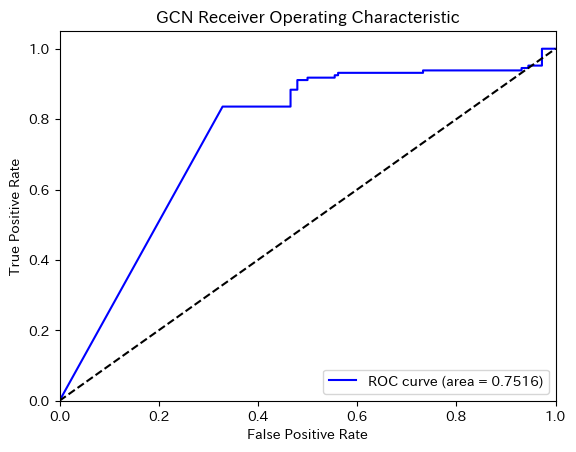

AUC Score: 0.7516
Accuracy: 0.5000
Optimal Threshold: 1.0000
Positive edge predictions (mean): 0.9718
Negative edge predictions (mean): 0.9201


In [22]:
gcn_predict_edges = []

# 学習済みモデルでリンク予測を実行
best_gcn_model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = best_gcn_model(test_data.x, test_data.edge_index)

    # テスト用正のエッジでの予測
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)
    
    # テスト用負のエッジでの予測
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index,
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)

    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy() 

    # ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))  # 実際に存在するエッジなので1
    neg_labels = torch.zeros(neg_pred.size(0))  # 存在しないエッジなので0
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    test_rocs["GCN"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    test_rocs["GCN"]["fpr"] = fpr
    test_rocs["GCN"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('GCN Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (predictions > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)

    # エッジを保存
    gcn_predict_edges = [(pos_edge_index[0,i].item(), pos_edge_index[1,i].item(), pos_pred[i].item()) for i in range(pos_edge_index.size(1))]
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### VGAEを用いたネットワーク生成

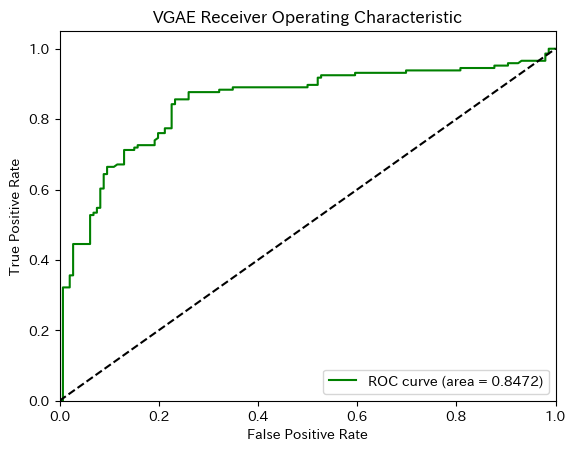

Val VGAE AUC Score: 0.8472
Accuracy: 0.8082
Optimal Threshold: 0.5777
Positive edge predictions (mean): 0.6674
Negative edge predictions (mean): 0.5609


In [23]:
vgae_predict_edges = []

best_vgae_model.eval()
with torch.no_grad():
    z = best_vgae_model.encode(test_data.x, test_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = best_vgae_model.decode(z, test_data.edge_index)

    # 正エッジを予測
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_pred = best_vgae_model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index, 
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = best_vgae_model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)
    test_rocs["VGAE"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)
    test_rocs["VGAE"]["fpr"] = fpr
    test_rocs["VGAE"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="green", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('VGAE Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (preds.numpy() > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)

    # エッジを保存
    prob = torch.sigmoid(z @ z.t())
    adj_matrix = (prob > optimal_threshold).nonzero(as_tuple=False).t().cpu()
    adj_matrix = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:val_data.num_edges]]
    vgae_predict_edges = adj_matrix.t().numpy()
    
    print(f"Val VGAE AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

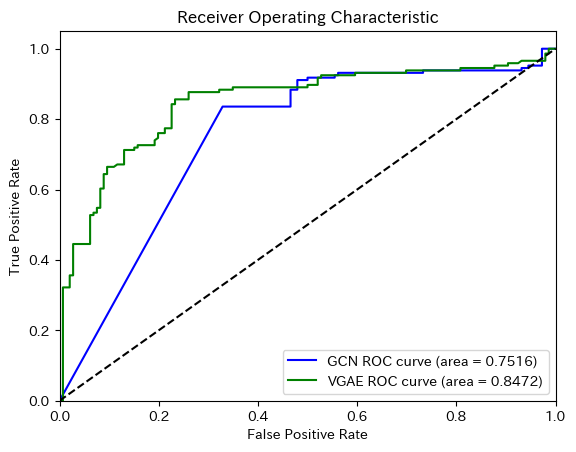

In [24]:
# GCNとVGAEのROC曲線をプロット
plt.figure()
plt.plot(test_rocs["GCN"]["fpr"], test_rocs["GCN"]["tpr"], color="blue", label='GCN ROC curve (area = {:.4f})'.format(test_rocs["GCN"]["auc"]))
plt.plot(test_rocs["VGAE"]["fpr"], test_rocs["VGAE"]["tpr"], color="green", label='VGAE ROC curve (area = {:.4f})'.format(test_rocs["VGAE"]["auc"]))
plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("/trust-engine/2025/ses_data/test_roc_curve.png")
plt.show()

### ネットワーク生成
- ネットワークを生成し中心性を算出し比較する

Original Test Graph: number of nodes=67, number of edges=74
GCN Generated Graph: number of nodes=134, number of edges=74
VGAE Generated Graph: number of nodes=133, number of edges=1013


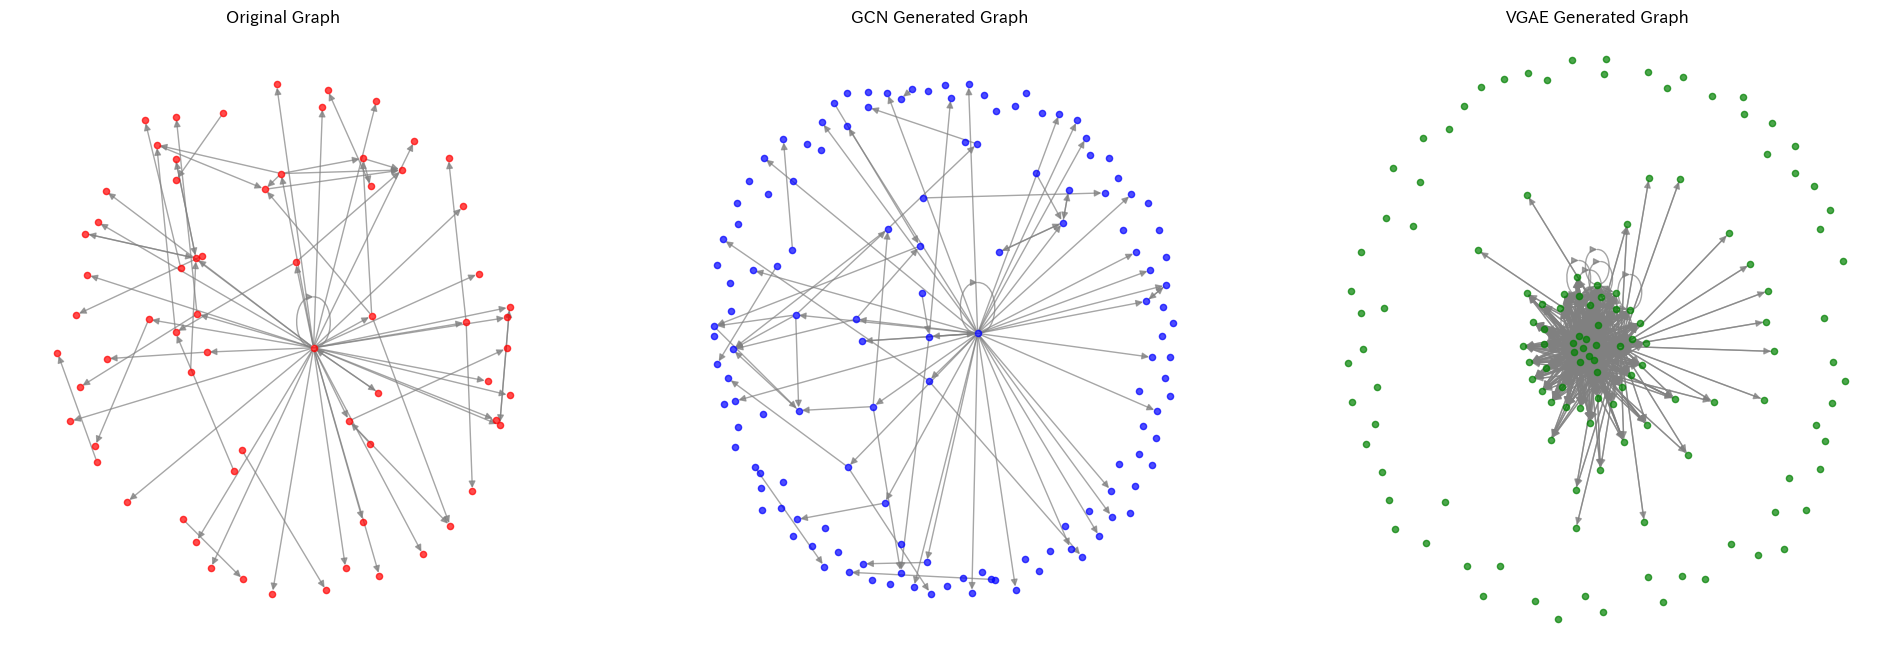

In [25]:
# GCNで予測したエッジからグラフを生成
gcn_gen_graph = nx.DiGraph()
gcn_gen_graph.add_nodes_from(list(test_graph.nodes))
for edge in gcn_predict_edges:
    gcn_gen_graph.add_edge(edge[0], edge[1])

# VGAEで予測したエッジからグラフを生成
vgae_gen_graph = nx.DiGraph()
vgae_gen_graph.add_nodes_from(list(test_graph.nodes))
for edge in vgae_predict_edges:
    vgae_gen_graph.add_edge(edge[0], edge[1])

# ノード数とエッジ数を表示
print(f"Original Test Graph: number of nodes={test_graph.number_of_nodes()}, number of edges={test_graph.number_of_edges()}")
print(f"GCN Generated Graph: number of nodes={gcn_gen_graph.number_of_nodes()}, number of edges={gcn_gen_graph.number_of_edges()}")
print(f"VGAE Generated Graph: number of nodes={vgae_gen_graph.number_of_nodes()}, number of edges={vgae_gen_graph.number_of_edges()}")

# グラフを可視化
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
pos_original = nx.spring_layout(test_graph, k=0.5, iterations=50)
nx.draw(test_graph, pos_original, with_labels=False, node_size=20, node_color='red', edge_color='gray', alpha=0.7)
plt.title("Original Graph")
plt.subplot(1, 3, 2)
pos_gcn = nx.spring_layout(gcn_gen_graph, k=0.5, iterations=50)
nx.draw(gcn_gen_graph, pos_gcn, with_labels=False, node_size=20, node_color='blue', edge_color='gray', alpha=0.7)
plt.title("GCN Generated Graph")
plt.subplot(1, 3, 3)
pos_vgae = nx.spring_layout(vgae_gen_graph, k=0.5, iterations=50)
nx.draw(vgae_gen_graph, pos_vgae, with_labels=False, node_size=20, node_color='green', edge_color='gray', alpha=0.7)
plt.title("VGAE Generated Graph")
plt.savefig("/trust-engine/2025/ses_data/graphs.png")
plt.show()

**元のネットワークの中心性を求める**

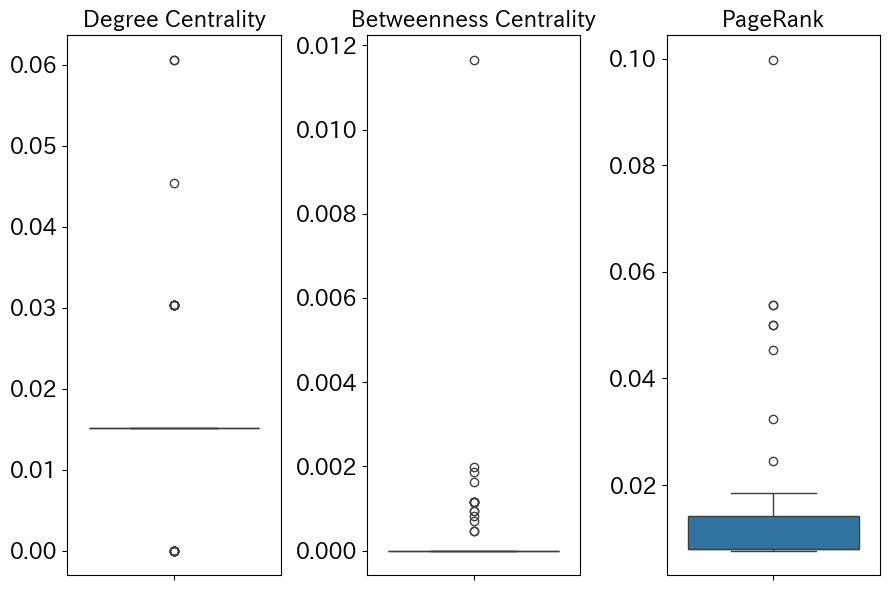

In [26]:
import seaborn as sns

# オリジナルグラフの中心性を計算
original_degree = nx.in_degree_centrality(test_graph)
original_betweenness = nx.betweenness_centrality(test_graph)
original_pagerank = nx.pagerank(test_graph)
df_centrality = pd.DataFrame({
    'degree': list(original_degree.values()),
    'betweenness': list(original_betweenness.values()),
    'pagerank': list(original_pagerank.values()),
})
df_centrality = df_centrality.melt(var_name='type', value_name='value')

# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(9, 6))
centrality_types = ['degree', 'betweenness', 'pagerank']
for i, centrality_type in enumerate(centrality_types):
    # 該当する中心性のデータのみを抽出
    data_subset = df_centrality[df_centrality['type'] == centrality_type]

    # 箱ひげ図を描画
    sns.boxplot(
        x='type', 
        y='value', 
        data=data_subset, 
        ax=axes[i], 
        hue='type',
    )

    # タイトルとラベルの設定
    if centrality_type == 'degree' or centrality_type == 'betweenness':
        axes[i].set_title(f'{centrality_type.capitalize()} Centrality', fontsize=16)
    else:
        axes[i].set_title(f'PageRank', fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].set_xticklabels([])  # x軸のラベルを非表示にする

plt.tight_layout()
plt.savefig("/trust-engine/2025/ses_data/original_centrality_boxplots.png")
plt.show()

**生成されたネットワークの中心性を求める**

In [27]:
centrality_list = []

# GCNで生成したネットワークの中心性を計算
gcn_degree = nx.in_degree_centrality(gcn_gen_graph)
gcn_betweenness = nx.betweenness_centrality(gcn_gen_graph)
gcn_pagerank = nx.pagerank(gcn_gen_graph)

# VGAEで生成したネットワークの中心性を計算
vgae_degree = nx.in_degree_centrality(vgae_gen_graph)
vgae_betweenness = nx.betweenness_centrality(vgae_gen_graph)
vgae_pagerank = nx.pagerank(vgae_gen_graph)

# GCNの中心性データを追加
for value in gcn_degree.values():
    centrality_list.append(["gcn", "degree", value])
for value in gcn_betweenness.values():
    centrality_list.append(["gcn", "betweenness", value])
for value in gcn_pagerank.values():
    centrality_list.append(["gcn", "pagerank", value])

# VGAEの中心性データを追加
for value in vgae_degree.values():
    centrality_list.append(["vgae", "degree", value])
for value in vgae_betweenness.values():
    centrality_list.append(["vgae", "betweenness", value])
for value in vgae_pagerank.values():
    centrality_list.append(["vgae", "pagerank", value])

# データフレームを作成
df_centrality = pd.DataFrame(centrality_list, columns=["type", "variable", "value"])
df_centrality = df_centrality.astype({
    "type": "category",
    "variable": "category", 
    "value": "float32"
})
for type in ["gcn", "vgae"]:
    print(f"--- {type} ---")
    for variable in ["degree", "betweenness", "pagerank"]:
        mean = df_centrality[(df_centrality['type'] == type) & (df_centrality['variable'] == variable)]['value'].mean()
        std = df_centrality[(df_centrality['type'] == type) & (df_centrality['variable'] == variable)]['value'].std()
        print(f"{variable}: mean={mean:.4f}, std={std:.4f}")

--- gcn ---
degree: mean=0.0042, std=0.0058
betweenness: mean=0.0000, std=0.0003
pagerank: mean=0.0075, std=0.0076
--- vgae ---
degree: mean=0.0577, std=0.1031
betweenness: mean=0.0014, std=0.0094
pagerank: mean=0.0075, std=0.0108


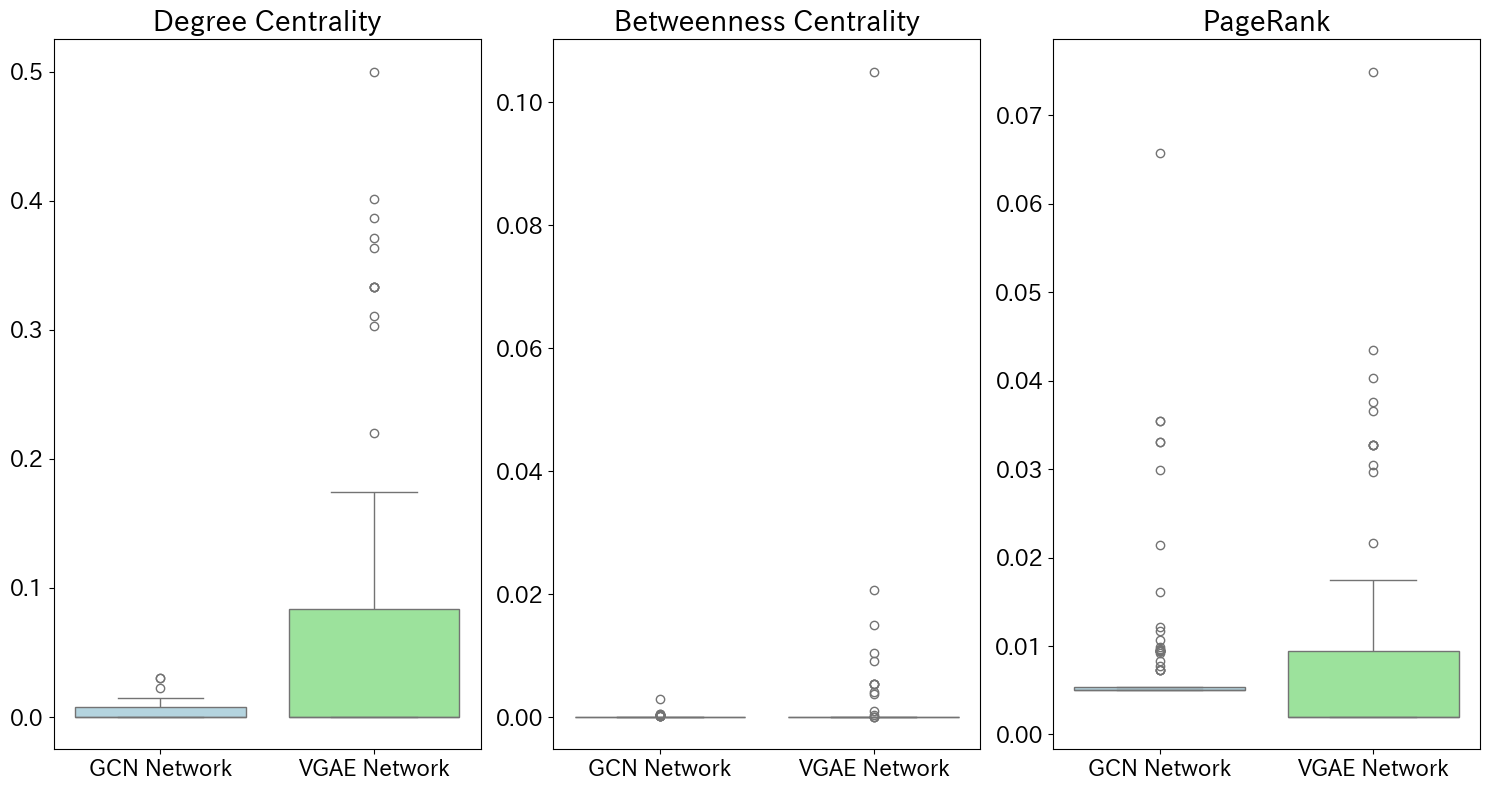

In [28]:
# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# 各中心性指標ごとにプロット
centrality_types = ['degree', 'betweenness', 'pagerank']
x_order = ['gcn', 'vgae']

for i, centrality_type in enumerate(centrality_types):
    # 該当する中心性のデータのみを抽出
    data_subset = df_centrality[df_centrality['variable'] == centrality_type]

    # 箱ひげ図を描画
    sns.boxplot(
        x='type', 
        y='value', 
        data=data_subset, 
        ax=axes[i], 
        order=x_order,
        hue='type',
        palette={"gcn": "lightblue", "vgae": "lightgreen"}
    )

    # タイトルとラベルの設定
    if centrality_type == 'degree' or centrality_type == 'betweenness':
        axes[i].set_title(f'{centrality_type.capitalize()} Centrality', fontsize=20)
    else:
        axes[i].set_title(f'PageRank', fontsize=20)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('', fontsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["GCN Network", "VGAE Network"], fontsize=16)

plt.tight_layout()
plt.savefig("/trust-engine/2025/ses_data/centrality_boxplots.png")
plt.show()